In [95]:
import math
import collections
import cv2
from IPython.display import clear_output

import numpy as np
import sympy as sy
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy.optimize import fsolve

from coppeliasim_zmqremoteapi_client import RemoteAPIClient

# 1. Object Detection

In [106]:
# 0.1. 클라이언트 생성  
client = RemoteAPIClient()
# 0.2. 시뮬레이션 객체 가져오기
sim = client.require("sim")

In [107]:
joints = []
# 5개의 관절 가져오기
for i in range(5):
    joints.append(sim.getObject(f"/youBotArmJoint{i}"))
# camera
camera_1 = sim.getObject(f"/camera_1")

In [113]:
def read_camera_1():
    result = sim.getVisionSensorImg(camera_1)
    img = np.frombuffer(result[0], dtype=np.uint8)
    img = img.reshape((result[1][1], result[1][0], 3))
    img = cv2.flip(img, 1)
    return img

In [114]:
def detect_red_box(img):
    image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # BGR에서 HSV로 변환
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # 빨간색의 HSV 범위 설정
    lower_red1 = np.array([0, 100, 100])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([160, 100, 100])
    upper_red2 = np.array([180, 255, 255])
    # 빨간색 마스크 생성
    mask1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
    red_mask = mask1 + mask2
    # 마스크를 이용해 원본 이미지에서 빨간색 부분 추출
    red_image = cv2.bitwise_and(image, image, mask=red_mask)
    # 컨투어 찾기
    contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # 원본 이미지에 컨투어(상자) 그리기
    bboxs = []
    for contour in contours:
        # 경계 상자 그리기
        x, y, w, h = cv2.boundingRect(contour)
        bboxs.append((x, y, w, h))
    return bboxs

In [122]:
import time

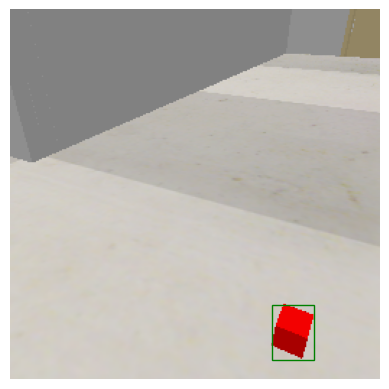

In [125]:
n_steps = 100

# start simulation
sim.setStepping(True)
sim.startSimulation()
for i in range(n_steps):
    if i == 1:
        time.sleep(5)
    sim.setJointTargetPosition(joints[0], i * 0.005)
    img = read_camera_1()
    bboxs = detect_red_box(img)
    clear_output(wait=True)
    plt.imshow(img)
    for  x, y, w, h in bboxs:
        rect = patches.Rectangle((x, y), w, h, linewidth=1,
                                               edgecolor='g',
                                               facecolor='none')
        plt.gca().add_patch(rect)
    plt.axis('off')
    plt.show()
    sim.step()

sim.stopSimulation()